In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa as lr
import librosa.display
from IPython.display import Audio
import warnings
%matplotlib inline

import os

In [2]:
warnings.filterwarnings("ignore")

In [3]:
SR = 3500

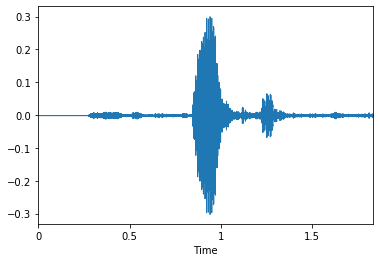

In [4]:
audio, sr = lr.load("./data/1/devi-khos-1a.wav", mono=True, sr=SR)
time = np.arange(0, len(audio)) / sr
plt.figure()
librosa.display.waveplot(audio, sr=sr)

In [5]:
Audio(audio, rate=SR)

In [6]:
def add_noise(data):
        noise = np.random.randn(len(data))
        data_noise = data + 0.005 * noise
        return data_noise

In [7]:
def shift(data):
        y_shift = data.copy()
        timeshift_fac = 0.2 *2*(np.random.uniform()-0.5)  # up to 20% of length
        
        start = int(y_shift.shape[0] * timeshift_fac)
        if (start > 0):
            y_shift = np.pad(y_shift,(start,0),mode='constant')[0:y_shift.shape[0]]
        else:
            y_shift = np.pad(y_shift,(0,-start),mode='constant')[0:y_shift.shape[0]]
        return y_shift

In [8]:
def stretch(data, rate=1):
        input_length = len(data)
        streching = data.copy()
        streching = librosa.effects.time_stretch(streching.astype('float'), 1.1)
        if len(streching) > input_length:
            streching = streching[:input_length]
        else:
            streching = np.pad(streching, (0, max(0, input_length - len(streching))), "constant")
        
        return streching

In [9]:
def pitch_and_speed(data):
    y_pitch_speed = data.copy()
    length_change = np.random.uniform(low=0.9, high = 1.1)
    speed_fac = 1.0  / length_change
    
    tmp = np.interp(np.arange(0,len(y_pitch_speed),speed_fac),np.arange(0,len(y_pitch_speed)),y_pitch_speed)
    minlen = min(y_pitch_speed.shape[0], tmp.shape[0])
    y_pitch_speed *= 0
    y_pitch_speed[0:minlen] = tmp[0:minlen]
    return y_pitch_speed

In [10]:
def pitch(data):
    y_pitch = data.copy()
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2 *(np.random.uniform())   
    y_pitch = librosa.effects.pitch_shift(y_pitch.astype('float64'), 
                                          sr, n_steps=pitch_change, 
                                          bins_per_octave=bins_per_octave)
    return y_pitch

In [11]:
def speed(data):
    y_speed = data.copy()
    speed_change = np.random.uniform(low=0.9,high=1.1)
    
    tmp = librosa.effects.time_stretch(y_speed.astype('float64'), speed_change)
    minlen = min(y_speed.shape[0], tmp.shape[0])
    y_speed *= 0 
    y_speed[0:minlen] = tmp[0:minlen]
    return y_speed

In [12]:
def augmentation(data):
    y_aug = data.copy()
    dyn_change = np.random.uniform(low=1.5,high=3)
    
    y_aug = y_aug * dyn_change
    return y_aug

In [13]:
def hpps(data):
    return librosa.effects.hpss(data.astype('float64'))[1]

In [14]:
def silent_to_the_right(data):
    sampling = data[(data > 0.001) | (data < -0.001)]
    shifted_silent = sampling.tolist() + np.zeros((data.shape[0] - sampling.shape[0])).tolist()
    return np.asarray(shifted_silent) 

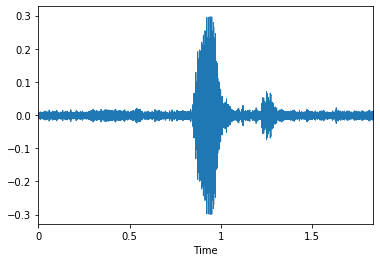

In [15]:
librosa.display.waveplot(add_noise(audio), sr=sr)

In [16]:
Audio(add_noise(audio), rate=sr)

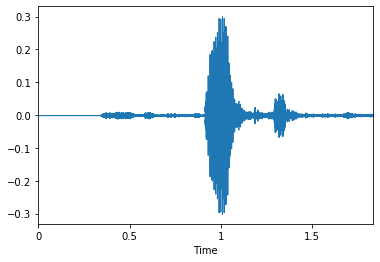

In [17]:
librosa.display.waveplot(shift(audio), sr=sr)

In [18]:
Audio(shift(audio), rate=sr)

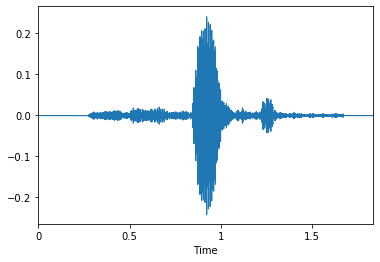

In [19]:
librosa.display.waveplot(stretch(audio), sr=sr)

In [20]:
Audio(stretch(audio), rate=sr)

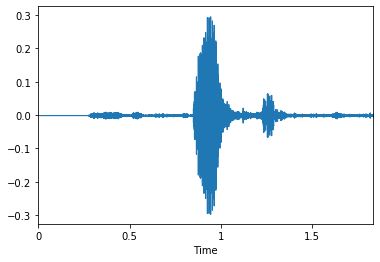

In [21]:
librosa.display.waveplot(pitch_and_speed(audio), sr=sr)

In [22]:
Audio(pitch_and_speed(audio), rate=sr)

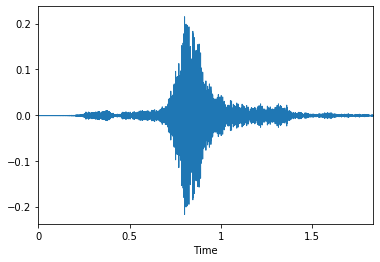

In [23]:
librosa.display.waveplot(pitch(audio), sr=sr)

In [24]:
Audio(pitch(audio), rate=sr)

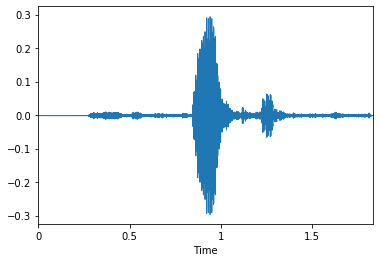

In [25]:
librosa.display.waveplot(speed(audio), sr=sr)

In [26]:
Audio(speed(audio), rate=sr)

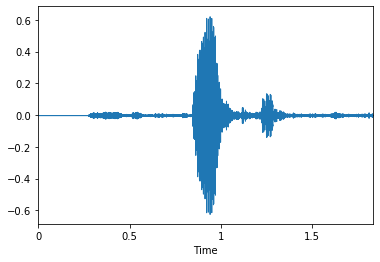

In [27]:
librosa.display.waveplot(augmentation(audio), sr=sr)

In [28]:
Audio(augmentation(audio), rate=sr)

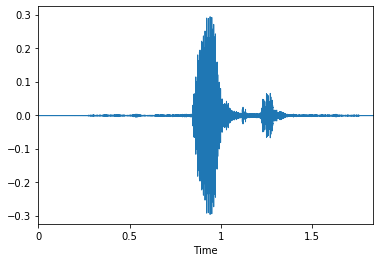

In [29]:
librosa.display.waveplot(hpps(audio), sr=sr)

In [30]:
Audio(hpps(audio), rate=sr)

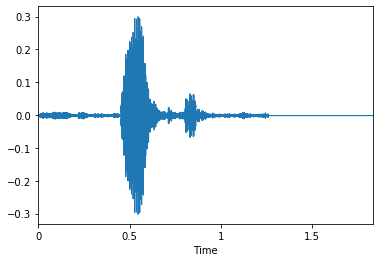

In [31]:
librosa.display.waveplot(silent_to_the_right(audio), sr=sr)

In [32]:
Audio(silent_to_the_right(audio), rate=sr)

In [33]:
def multiply_audio(audio):
    audios = []
    audios.append(audio)
    audios.append(add_noise(audio))
    
    audios.append(stretch(audio))
    audios.append(add_noise(stretch(audio)))
    
    audios.append(pitch_and_speed(audio))
    audios.append(add_noise(pitch_and_speed(audio)))
    
    audios.append(pitch(audio))
    audios.append(add_noise(pitch(audio)))
    
    audios.append(speed(audio))
    audios.append(add_noise(speed(audio)))
    
    audios.append(augmentation(audio))
    audios.append(add_noise(augmentation(audio)))
    
    audios.append(hpps(audio))
    audios.append(add_noise(hpps(audio)))
    
    audios.append(silent_to_the_right(audio))
    audios.append(add_noise(silent_to_the_right(audio)))
    return audios

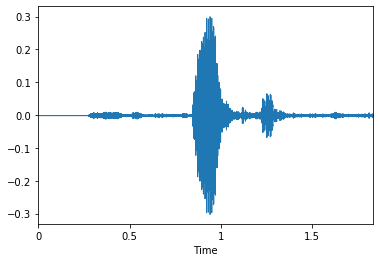

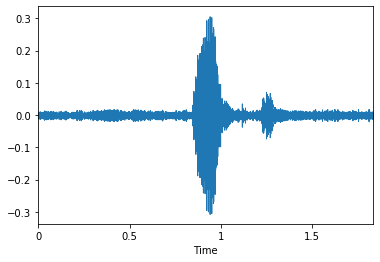

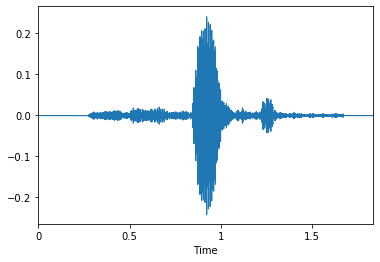

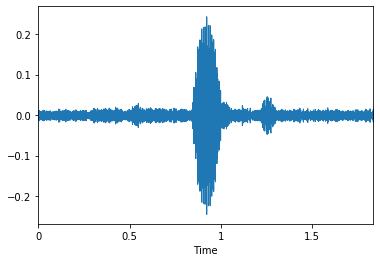

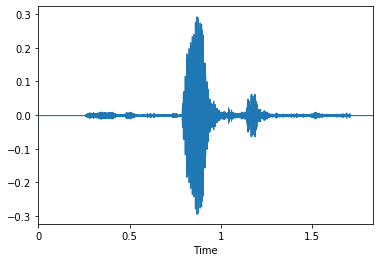

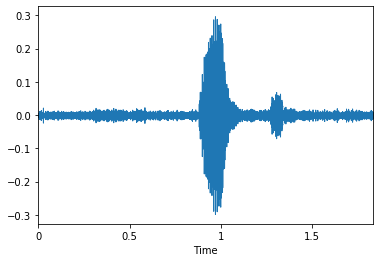

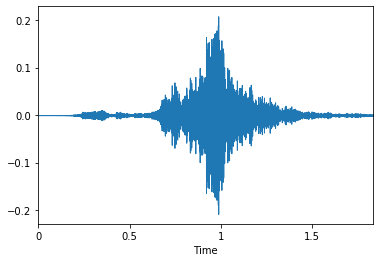

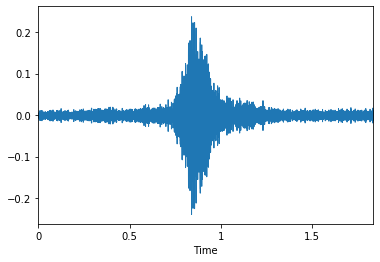

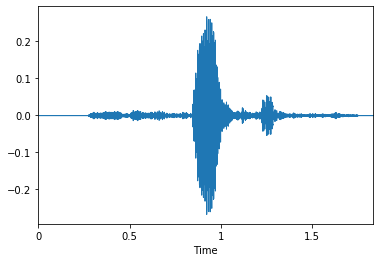

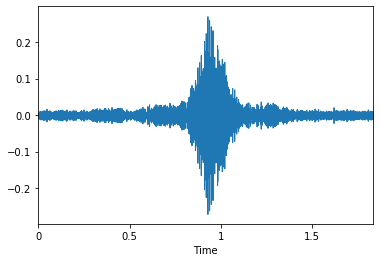

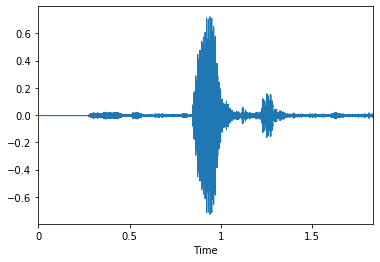

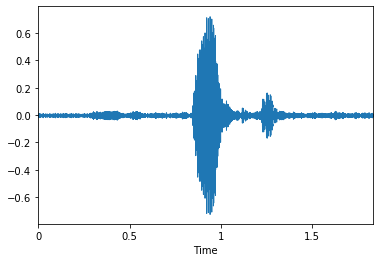

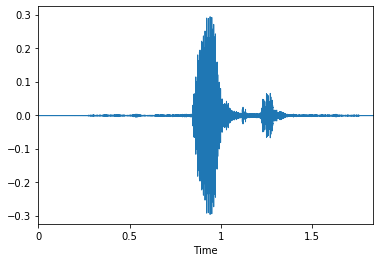

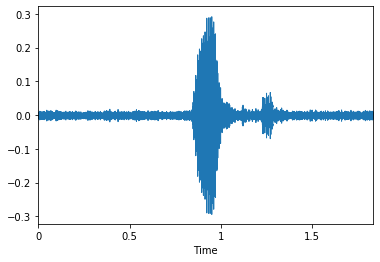

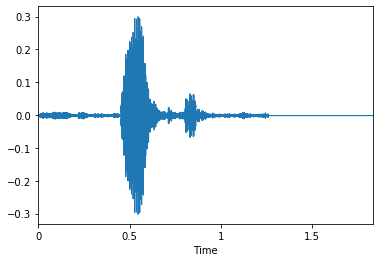

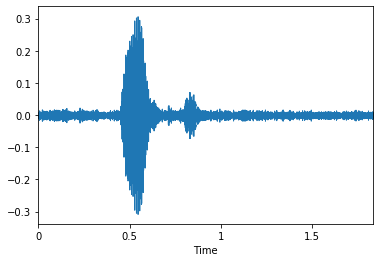

In [34]:
for curr_audio in multiply_audio(audio):
    plt.figure()
    librosa.display.waveplot(curr_audio, sr=sr)

In [35]:
labels, voices = [], []

In [36]:
for dirpath, dirnames, filenames in os.walk('./data'):
    try:
        label = int(dirpath.split("/")[-1])
    except:
        pass
    
    for filename in filenames:
        try:
            audio, sr = lr.load(os.path.join(dirpath, filename), mono=True, sr=SR)
            time = np.arange(0, len(audio)) / sr
#             plt.figure()
#             librosa.display.waveplot(audio, sr=sr)
#             plt.title(f"{filename}")
            labels.append(label)
            voices.append(audio)
        except:
            print(f"ERROR ON: {os.path.join(dirpath, filename)}")

(array([ 23.,  46., 118., 225., 127.,  93.,  37.,  16.,   2.,   1.]),
 array([ 1458. ,  2610.5,  3763. ,  4915.5,  6068. ,  7220.5,  8373. ,
         9525.5, 10678. , 11830.5, 12983. ]),
 <a list of 10 Patch objects>)

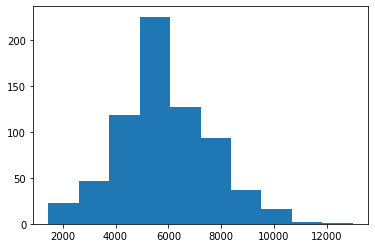

In [37]:
lengths = list(map(len, voices))
lengths.sort()
plt.hist(lengths)

In [38]:
max_length = max(lengths)
max_length

12983

In [39]:
voice = voices[220]
Audio(voice, rate=SR)

In [40]:
mfcc = librosa.feature.mfcc(voices[220], sr=SR, n_mfcc=20)
mfcc.shape

(20, 11)

In [41]:
padded_voices = voices.copy()
padded_voices = list(map(lambda v: np.pad(v, (0, max_length - len(v)), mode="constant"), padded_voices))

In [42]:
max(list(map(len, padded_voices))) == min(list(map(len, padded_voices)))

True

In [43]:
mfccs = [librosa.feature.mfcc(voice, sr=SR, n_mfcc=20) for voice in padded_voices]

In [44]:
mean_mfccs = [m.mean(axis=0) for m in mfccs]

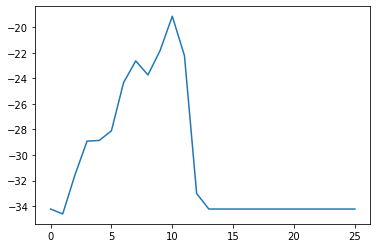

In [45]:
plt.plot(mean_mfccs[220])

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mean_mfccs, labels, train_size=0.9)
model = LogisticRegression(max_iter=1000, C=10)

In [47]:
model.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
model.score(X_test, y_test)

0.21739130434782608